<a href="https://colab.research.google.com/github/minhdinh03/FlowerClassificationProject/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, Model
from typing import Tuple
tf.compat.v1.enable_eager_execution()


os.environ["cuda_visible_devices"]="0" 

from glob import glob
import io
from PIL import Image

import math, re, os
import numpy as np

from collections import Counter

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.9.0-dev20220115


In [ ]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""PREPROCESSING"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'PREPROCESSING'

In [ ]:
IMAGE_SIZE = [224, 224]
PATH = 'C:/Users/Dat Nguyen/Desktop/Assignments/Machine Learning/New folder/combined_data_splitted'

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16

TRAIN_PATH = tf.io.gfile.glob(PATH + '/train/*.tfrecord')
VAL_PATH = tf.io.gfile.glob(PATH + '/validation/*.tfrecord')
TEST_PATH = tf.io.gfile.glob(PATH + '/test/*.tfrecord')

In [ ]:
CLASSES = ['pink primrose',
 'wild geranium',
 'spear thistle',
 'yellow iris',
 'wallflower',
 'buttercup',
 'daisy',
 'common dandelion',
 'petunia',
 'sunflower',
 'iris',
 'windflower',
 'water lily',
 'rose',
 'morning glory',
 'frangipani',
 'cyclamen ',
 'foxglove',
 'common tulip',
 'wild rose']

In [ ]:

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def duplicate_label(image, label):
  return image, (label, label, label)

def data_augment(image, label):
    # Thanks to the dataset.prefetch(AUTO)
    # statement in the next function (below), this happens essentially
    # for free on TPU. Data pipeline code is executed on the "CPU"
    # part of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   


def get_training_dataset(path = TRAIN_PATH, labeled = True):
    dataset = load_dataset(path)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.shuffle(6536)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(path = VAL_PATH):
    dataset = load_dataset(path)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(path = TEST_PATH):
    dataset = load_dataset(path)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset


In [ ]:
ds_train = get_training_dataset()
ds_val = get_validation_dataset()
ds_test = get_test_dataset()

In [ ]:
ds_train = ds_train.map(duplicate_label, num_parallel_calls=AUTO)
ds_val = ds_val.map(duplicate_label, num_parallel_calls=AUTO)
ds_test = ds_test.map(duplicate_label, num_parallel_calls=AUTO)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""NETWORK DESIGN"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'NETWORK DESIGN'

In [ ]:
def inception(x,
              filters_1x1,
              filters_3x3_reduce,
              filters_3x3,
              filters_5x5_reduce,
              filters_5x5,
              filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)

  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)

  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)

  return tf.concat([path1, path2, path3, path4], axis=3)

In [ ]:
inp = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(inp)
x = layers.MaxPooling2D(3, strides=2)(x)

x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=64,
              filters_3x3_reduce=96,
              filters_3x3=128,
              filters_5x5_reduce=16,
              filters_5x5=32,
              filters_pool=32)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=192,
              filters_5x5_reduce=32,
              filters_5x5=96,
              filters_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=192,
              filters_3x3_reduce=96,
              filters_3x3=208,
              filters_5x5_reduce=16,
              filters_5x5=48,
              filters_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(20, activation='softmax')(aux1)

x = inception(x,
              filters_1x1=160,
              filters_3x3_reduce=112,
              filters_3x3=224,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=128,
              filters_3x3_reduce=128,
              filters_3x3=256,
              filters_5x5_reduce=24,
              filters_5x5=64,
              filters_pool=64)

x = inception(x,
              filters_1x1=112,
              filters_3x3_reduce=144,
              filters_3x3=288,
              filters_5x5_reduce=32,
              filters_5x5=64,
              filters_pool=64)

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(20, activation='softmax')(aux2)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              filters_1x1=256,
              filters_3x3_reduce=160,
              filters_3x3=320,
              filters_5x5_reduce=32,
              filters_5x5=128,
              filters_pool=128)

x = inception(x,
              filters_1x1=384,
              filters_3x3_reduce=192,
              filters_3x3=384,
              filters_5x5_reduce=48,
              filters_5x5=128,
              filters_pool=128)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.4)(x)
out = layers.Dense(20, activation='softmax')(x)

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy, losses.sparse_categorical_crossentropy], loss_weights=[1, 0.3, 0.3], metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']                 
                                                                                              

                                                                                                  
 conv2d_24 (Conv2D)             (None, 13, 13, 224)  25312       ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 13, 13, 64)   1600        ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 13, 13, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 tf.concat_3 (TFOpLambda)       (None, 13, 13, 512)  0           ['conv2d_22[0][0]',              
                                                                  'conv2d_24[0][0]',              
                                                                  'conv2d_26[0][0]',              
          

 conv2d_51 (Conv2D)             (None, 6, 6, 128)    4224        ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 6, 6, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 tf.concat_7 (TFOpLambda)       (None, 6, 6, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
                                                                                                  
 conv2d_54 (Conv2D)             (None, 6, 6, 192)    159936      ['tf.concat_7[0][0]']            
          

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_dense_4_accuracy',min_delta = 0.05, mode = "max" ,patience=15, restore_best_weights=True)
callbacks = [early_stop]
history = model.fit(ds_train, validation_data=ds_val, epochs=120, callbacks = callbacks)


Epoch 1/120
409/409 [==============================] - 56s 110ms/step - loss: 4.5219 - dense_4_loss: 2.8241 - dense_1_loss: 2.8227 - dense_3_loss: 2.8364 - dense_4_accuracy: 0.1327 - dense_1_accuracy: 0.1371 - dense_3_accuracy: 0.1383 - val_loss: 4.5099 - val_dense_4_loss: 2.8227 - val_dense_1_loss: 2.8010 - val_dense_3_loss: 2.8228 - val_dense_4_accuracy: 0.1550 - val_dense_1_accuracy: 0.1500 - val_dense_3_accuracy: 0.1550
Epoch 2/120
409/409 [==============================] - 41s 96ms/step - loss: 4.2335 - dense_4_loss: 2.6510 - dense_1_loss: 2.6194 - dense_3_loss: 2.6558 - dense_4_accuracy: 0.1651 - dense_1_accuracy: 0.1728 - dense_3_accuracy: 0.1663 - val_loss: 3.8342 - val_dense_4_loss: 2.4179 - val_dense_1_loss: 2.3228 - val_dense_3_loss: 2.3982 - val_dense_4_accuracy: 0.2293 - val_dense_1_accuracy: 0.2586 - val_dense_3_accuracy: 0.2429
Epoch 3/120
409/409 [==============================] - 41s 96ms/step - loss: 3.8778 - dense_4_loss: 2.4266 - dense_1_loss: 2.4026 - dense_3_loss:

409/409 [==============================] - 45s 99ms/step - loss: 2.3086 - dense_4_loss: 1.4277 - dense_1_loss: 1.4700 - dense_3_loss: 1.4664 - dense_4_accuracy: 0.5275 - dense_1_accuracy: 0.5177 - dense_3_accuracy: 0.5261 - val_loss: 2.2802 - val_dense_4_loss: 1.4322 - val_dense_1_loss: 1.3949 - val_dense_3_loss: 1.4315 - val_dense_4_accuracy: 0.5300 - val_dense_1_accuracy: 0.5621 - val_dense_3_accuracy: 0.5371
Epoch 21/120
409/409 [==============================] - 46s 99ms/step - loss: 2.2794 - dense_4_loss: 1.4141 - dense_1_loss: 1.4420 - dense_3_loss: 1.4424 - dense_4_accuracy: 0.5366 - dense_1_accuracy: 0.5265 - dense_3_accuracy: 0.5287 - val_loss: 2.2090 - val_dense_4_loss: 1.3638 - val_dense_1_loss: 1.4066 - val_dense_3_loss: 1.4108 - val_dense_4_accuracy: 0.5479 - val_dense_1_accuracy: 0.5529 - val_dense_3_accuracy: 0.5450
Epoch 22/120
409/409 [==============================] - 46s 99ms/step - loss: 2.1960 - dense_4_loss: 1.3615 - dense_1_loss: 1.3979 - dense_3_loss: 1.3839 - d

409/409 [==============================] - 48s 101ms/step - loss: 1.6972 - dense_4_loss: 1.0335 - dense_1_loss: 1.1298 - dense_3_loss: 1.0826 - dense_4_accuracy: 0.6595 - dense_1_accuracy: 0.6352 - dense_3_accuracy: 0.6523 - val_loss: 2.0216 - val_dense_4_loss: 1.2709 - val_dense_1_loss: 1.2461 - val_dense_3_loss: 1.2562 - val_dense_4_accuracy: 0.6100 - val_dense_1_accuracy: 0.6071 - val_dense_3_accuracy: 0.6179
Epoch 40/120
409/409 [==============================] - 49s 101ms/step - loss: 1.6534 - dense_4_loss: 1.0052 - dense_1_loss: 1.0973 - dense_3_loss: 1.0636 - dense_4_accuracy: 0.6699 - dense_1_accuracy: 0.6379 - dense_3_accuracy: 0.6546 - val_loss: 2.0466 - val_dense_4_loss: 1.2663 - val_dense_1_loss: 1.3257 - val_dense_3_loss: 1.2754 - val_dense_4_accuracy: 0.6071 - val_dense_1_accuracy: 0.5921 - val_dense_3_accuracy: 0.6064
Epoch 41/120
409/409 [==============================] - 49s 101ms/step - loss: 1.6481 - dense_4_loss: 1.0039 - dense_1_loss: 1.0963 - dense_3_loss: 1.0510 

409/409 [==============================] - 51s 102ms/step - loss: 1.3355 - dense_4_loss: 0.7960 - dense_1_loss: 0.9244 - dense_3_loss: 0.8740 - dense_4_accuracy: 0.7350 - dense_1_accuracy: 0.6952 - dense_3_accuracy: 0.7224 - val_loss: 2.1578 - val_dense_4_loss: 1.3372 - val_dense_1_loss: 1.3574 - val_dense_3_loss: 1.3782 - val_dense_4_accuracy: 0.6221 - val_dense_1_accuracy: 0.6321 - val_dense_3_accuracy: 0.6300
Epoch 59/120
409/409 [==============================] - 51s 102ms/step - loss: 1.3242 - dense_4_loss: 0.7908 - dense_1_loss: 0.9198 - dense_3_loss: 0.8581 - dense_4_accuracy: 0.7399 - dense_1_accuracy: 0.7068 - dense_3_accuracy: 0.7238 - val_loss: 2.1118 - val_dense_4_loss: 1.2933 - val_dense_1_loss: 1.4000 - val_dense_3_loss: 1.3284 - val_dense_4_accuracy: 0.6293 - val_dense_1_accuracy: 0.6229 - val_dense_3_accuracy: 0.6214
Epoch 60/120
409/409 [==============================] - 50s 103ms/step - loss: 1.2771 - dense_4_loss: 0.7573 - dense_1_loss: 0.8992 - dense_3_loss: 0.8332 

409/409 [==============================] - 52s 103ms/step - loss: 1.1072 - dense_4_loss: 0.6416 - dense_1_loss: 0.7963 - dense_3_loss: 0.7557 - dense_4_accuracy: 0.7890 - dense_1_accuracy: 0.7386 - dense_3_accuracy: 0.7573 - val_loss: 2.2919 - val_dense_4_loss: 1.3905 - val_dense_1_loss: 1.4710 - val_dense_3_loss: 1.5338 - val_dense_4_accuracy: 0.6493 - val_dense_1_accuracy: 0.6450 - val_dense_3_accuracy: 0.6521
Epoch 78/120
409/409 [==============================] - 51s 103ms/step - loss: 1.0630 - dense_4_loss: 0.6130 - dense_1_loss: 0.7845 - dense_3_loss: 0.7156 - dense_4_accuracy: 0.8006 - dense_1_accuracy: 0.7538 - dense_3_accuracy: 0.7720 - val_loss: 2.4928 - val_dense_4_loss: 1.5436 - val_dense_1_loss: 1.6614 - val_dense_3_loss: 1.5025 - val_dense_4_accuracy: 0.6079 - val_dense_1_accuracy: 0.6093 - val_dense_3_accuracy: 0.6107
Epoch 79/120
409/409 [==============================] - 52s 103ms/step - loss: 1.0325 - dense_4_loss: 0.5957 - dense_1_loss: 0.7630 - dense_3_loss: 0.6931 

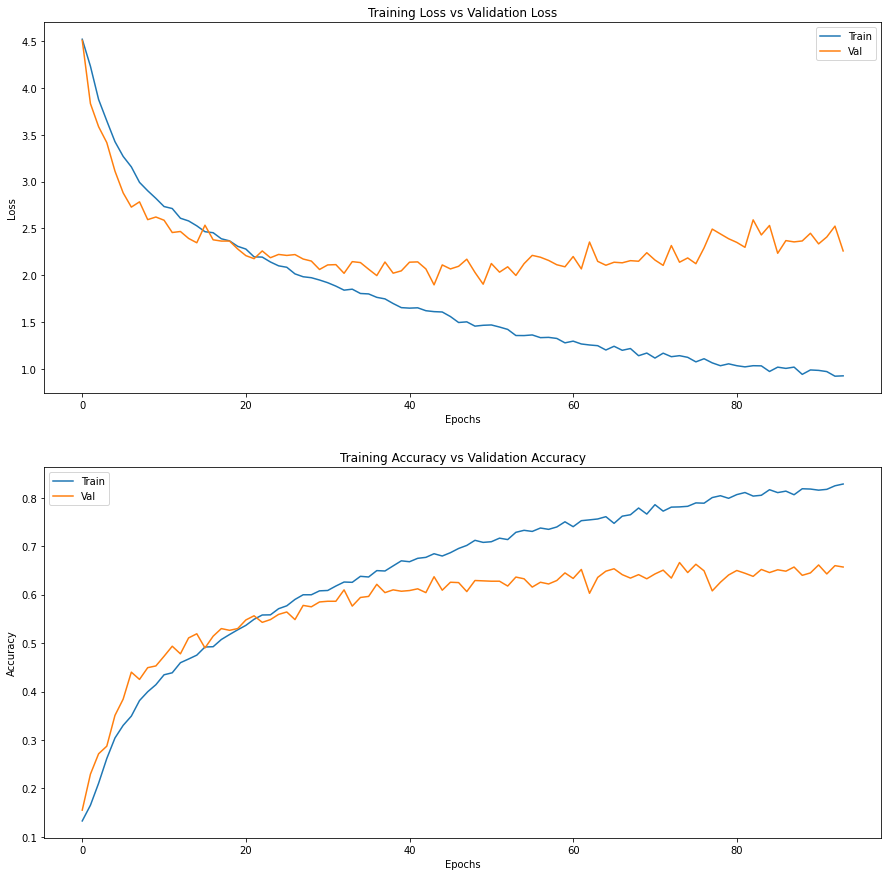

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.save("Path")